In [1]:
from sklearn import preprocessing, model_selection
import csv
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
def get_dataset(directory, lag, excluded_name=[]):
    data = pd.DataFrame(columns=['data', 'label'])
    for foldername in os.listdir(directory):        
        folder = os.path.join(directory, foldername)
        # print(folder)
        if str(lag) in folder:
            # print(os.listdir(folder))
            for name in os.listdir(folder):
                if name in excluded_name:
                    # print(name)
                    continue
                filename = os.path.join(folder, name)
                # print(filename)
                for files in os.listdir(filename):
                    rel_path = os.path.join(filename, files)
                    # print(rel_path)
                    temp_label = folder
                    if "autism" in temp_label:
                        label = 'autism'
                    else:
                        label = 'normal'

                    temp_data = pd.DataFrame(columns=['data', 'label'], index=[0])

                    rwb = np.load(rel_path)
                    rwb.astype(np.float64).reshape(-1,1)
                                    
                    temp_data.loc[0, "data"] = rwb
                    temp_data['label'] = label
                    data = pd.concat([data, temp_data], ignore_index=True)
    label_map = {"autism": 1, "normal": 0}
    data['label_map'] = data['label'].map(label_map)      
    return data

In [3]:
def remove_missing_value(data):
    series_list = np.vstack(data["data"].values)
    labels_list = data["label_map"].values    
    missing_indices = np.where(np.isnan(series_list).any(axis=1))[0]

    clean_data = data.drop(index=data.index[missing_indices])
    return clean_data

In [4]:
data_dir = "datasets/features/rwb/segment_1 seconds"

# train_dir = "datasets/tf_batch/rwb/segment_1 seconds/train"
# test_dir = "datasets/tf_batch/rwb/segment_1 seconds/test"

In [5]:
excluded = ["zyad"]
train_split = 0.8
LAG = [256]

for lag in LAG:
    data = get_dataset(data_dir, lag, excluded)
    print(data.shape)
    data = remove_missing_value(data)
    print(data.shape)


(15434, 3)
(14618, 3)


In [6]:
dwt_components = ['A5','D5','D4','D3','D2','D1']
channels = ['Fp1', 'F3', 'F7', 'T3', 'T5', 'O1', 'C4', 'FP2', 'Fz', 'F4', 'F8', 'C3', 'Cz', 'Pz', 'Oz', 'O2']

columns_name = [f"{ch}_{comp}"  for ch in channels for comp in dwt_components]


In [7]:
df = pd.DataFrame()
df[columns_name] = np.vstack(data["data"].values)
df["label"] = data["label_map"]
print(df.shape)
df.dropna(inplace=True)
print(df.shape)

(14618, 97)
(13802, 97)


In [8]:
X = df.drop("label", axis=1)
y = df["label"]

## Chi-square Test

In [10]:
from sklearn.feature_selection import chi2

chi_score = chi2(X, y)
p_val = pd.Series(chi_score[1], index = X.columns)
p_val_sorted = p_val.sort_values(ascending=False)
p_val_sorted.to_csv("p_val_sorted.csv", index=True)

### Anova Test

In [10]:
from sklearn.feature_selection import f_classif

F_values, p_values = f_classif(X, y)
important_features = pd.Series(p_values, index=X.columns)
# important_features = important_features[important_features < 0.05]  # threshold 0.
important_features.sort_values(ascending=False).to_csv("anova-p-value.csv", index=True)

### Logistic Regression Coeff.

In [21]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=2000)
model.fit(X, y)

feature_importance = pd.Series(model.coef_[0], index=X.columns)
important_features = feature_importance.abs().sort_values(ascending=False)
important_features.to_csv("log-coef.csv", index=True)

c:\Users\farra\anaconda3\envs\eeg_env\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Information Gain

In [22]:
from sklearn.feature_selection import mutual_info_classif

mi = mutual_info_classif(X, y)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)
mi_series.to_csv("mutual_info.csv", index=True)

### PCA

In [34]:
from sklearn.decomposition import PCA

# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

pca = PCA()
pca.fit(X)

explained_variance = pca.explained_variance_ratio_
loadings = pd.DataFrame(pca.components_, columns=X.columns)

num_components_to_inspect = 24
top_features = loadings.iloc[:num_components_to_inspect].abs().sum().sort_values(ascending=False)

print("Explained variance ratio of the principal components:", explained_variance[:num_components_to_inspect])
print("Most important features based on PCA loadings:")
print(top_features)
top_features.to_csv("pca_top_feature_24_comp.csv", index=True)


Explained variance ratio of the principal components: [0.51874824 0.10331394 0.04924718 0.03841878 0.03344321 0.02729477
 0.02511498 0.02001809 0.01724392 0.01537779 0.01474073 0.01393707
 0.01355438 0.01225733 0.01155834 0.01122696 0.01019072 0.0087036
 0.00767435 0.00509652 0.00465917 0.00355994 0.00306065 0.00266231]
Most important features based on PCA loadings:
Fp1_A5    3.643722
FP2_A5    3.436468
F7_A5     3.302933
F3_A5     3.257993
T3_A5     3.249289
            ...   
O2_D5     0.241736
Fz_D5     0.236721
Fp1_D5    0.222693
Cz_D5     0.220467
FP2_D5    0.162095
Length: 96, dtype: float64


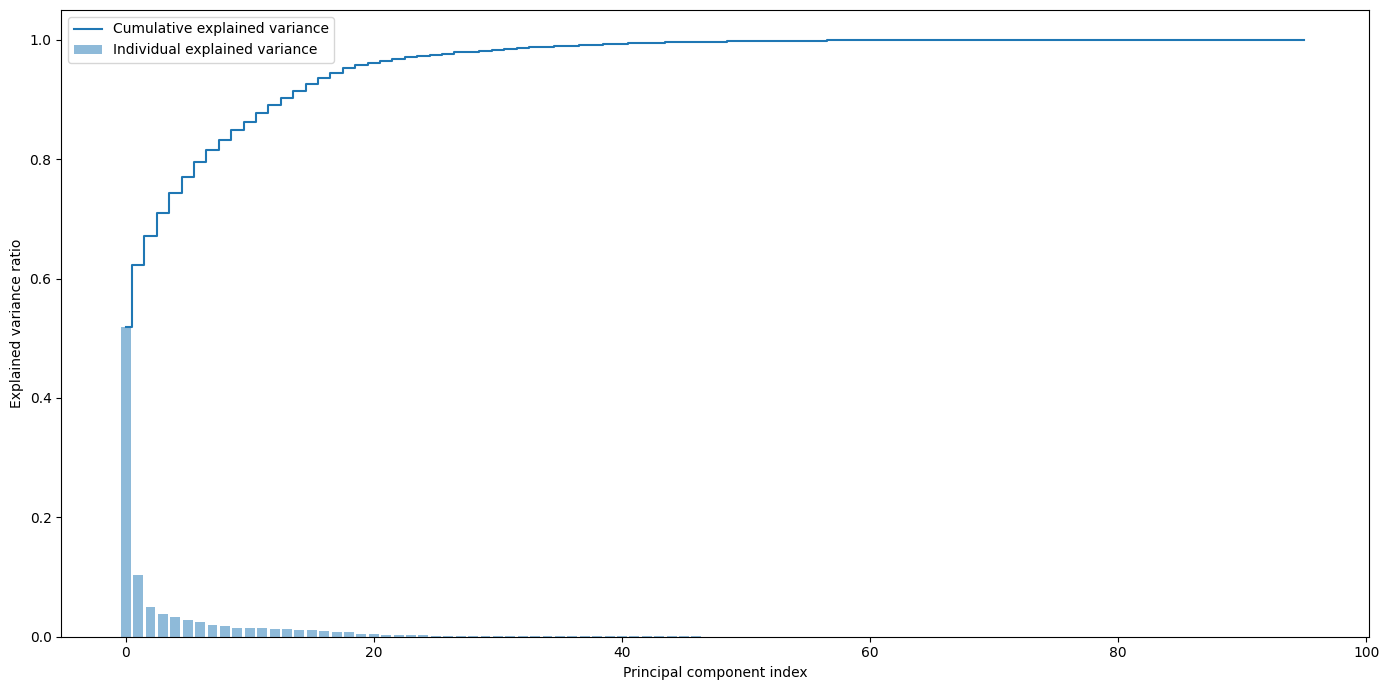

In [31]:
cum_sum_eigenvalues = np.cumsum(explained_variance)

plt.figure(figsize=(14,7))
plt.bar(range(0,len(explained_variance)), explained_variance, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

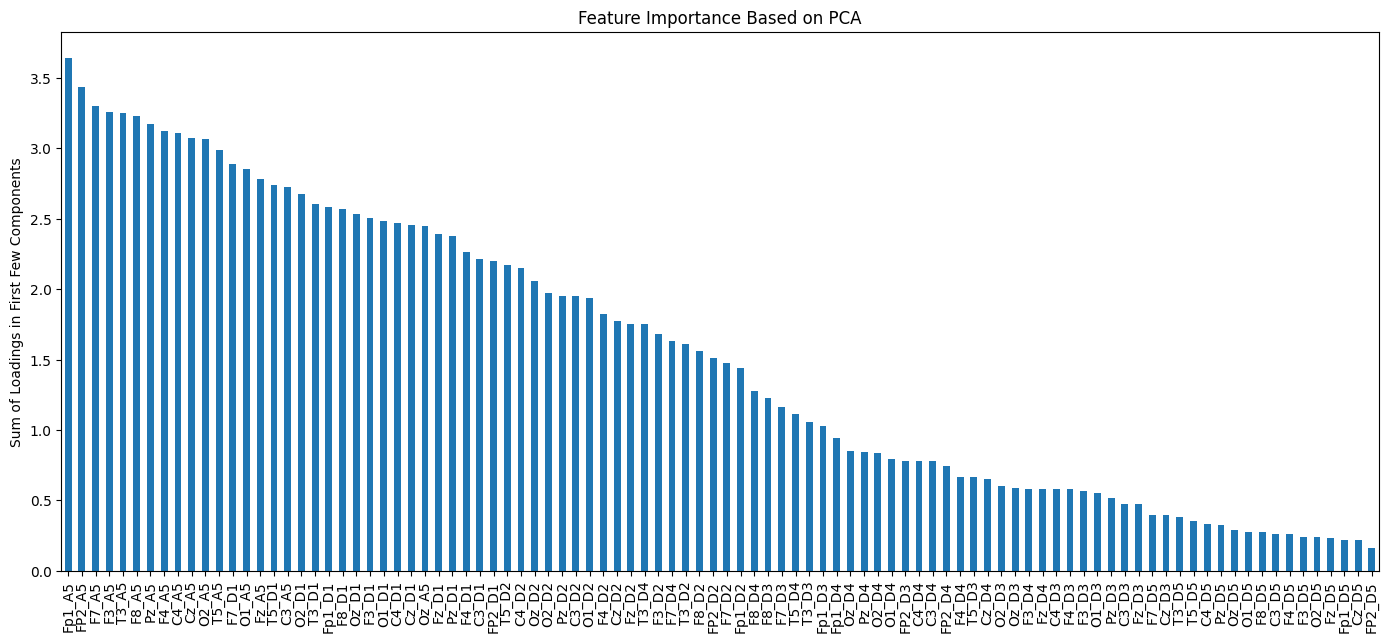

In [35]:
top_features.plot(kind='bar',  figsize=(17,7))
plt.title('Feature Importance Based on PCA')
plt.ylabel('Sum of Loadings in First Few Components')
plt.show()